# Damage Assessment from image during natural disasters

# Download and Preprocessing

For the AWS disaster response hackathon one of the challenge is to answer the question : **HOW MIGHT WE ACCURATELY AND EFFICIENTLY DETERMINE THE EXTENT OF DAMAGE TO INDIVIDUAL HOMES IN A GIVEN DISASTER-IMPACTED AREA ?**

To answer that question our team proposed to build and deploy an edge-based computer vision solution on smartphones for damage assessment.

In [1]:
#%pip install pandas
#%pip install tensorflow
#%pip install tensorflow_addons
#%pip install matplotlib

In [4]:
import os
import re
import gc
import wget
import tarfile
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras import optimizers, callbacks,models,layers
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,balanced_accuracy_score


In [5]:
print(tf.__version__)

2.7.1


## Check your working directory

Subsequent sessions may require you to identify and update your working directory so paths correctly point at the downloaded data files. You can check your working directory like so:

In [6]:
# Working Directory
cwd = os.getcwd()
cwd

'c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml\\notebooks'

You can simply assign the working directory to be 'one level above the current directory' by running this line of code with the `..` as the path. 
  
`..` means 'one directory above the current directory.You should be in the noteboks directory, we need to download extract data one level above in the `data` folder.

**Note you should only run it once! If you run it multiple times, you will keep reseting the working directory to one level above the current directory, until you reach the root of the drive!**

In [7]:
# Set Working Directory (if needed)
# you can just do this:
os.chdir(r"..") 

In [11]:
# Confirm it changed the working Directory
print("My working directory:\n" + os.getcwd())
cwd = os.getcwd()
cwd

My working directory:
c:\Users\wsn8\Code\disaster-damage-assessment-ml


'c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml'

## Download the data

Images collected from Twitter during four natural disasters, namely Typhoon Ruby (2014), Nepal Earthquake (2015), Ecuador Earthquake (2016), and Hurricane Matthew (2016). In addition to Twitter images, it contains images collected from Google using queries such as "damage building", "damage bridge", and "damage road" to deal with labeled data scarcity problem. The images are labeled in 3 classes:
* Severe
* Mild
* None

In [12]:
IMAGE_FOLDER = 'ASONAM17_Damage_Image_Dataset'
FILENAME = 'ASONAM17_Damage_Image_Dataset.tar.gz'
DATA_PATH = os.path.join(cwd, 'data')
IMAGES_PATH = os.path.join(cwd,'data',IMAGE_FOLDER)
FILE_PATH = os.path.join(cwd,'data',FILENAME)
DATA_PATH,IMAGES_PATH,FILE_PATH

('c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml\\data',
 'c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml\\data\\ASONAM17_Damage_Image_Dataset',
 'c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml\\data\\ASONAM17_Damage_Image_Dataset.tar.gz')

In [13]:
def download_images(target_path):
    url = 'https://crisisnlp.qcri.org/data/ASONAM17_damage_images/ASONAM17_Damage_Image_Dataset.tar.gz'
    target_path = target_path
    filename = wget.download(url=url, out=target_path)
    return filename

def extract_images(target_path, filename='ASONAM17_Damage_Image_Dataset.tar.gz'):

    print(target_path + filename)

    tar = tarfile.open(target_path+filename)
    tar.extractall(path=target_path)
    tar.close()

In [14]:
# check if folder or images already exits first
if os.path.isdir(IMAGES_PATH) and os.path.exists(FILE_PATH):
    print("data already downloaded and extracted ")
else:
    print("downloading and extracting images data")
    filename = download_images(DATA_PATH)
    extract_images(target_path=DATA_PATH, filename=filename)

data already downloaded and extracted 


## Get data and convert image path and label to csv

In [15]:
import csv
os.makedirs(f"{cwd}/data/damage_csv",exist_ok=True)
DAMAGE_PATH = os.path.join(cwd,'data',"damage_csv")

print(IMAGES_PATH)
print(DAMAGE_PATH)

def _get_train_files_by_event(images_path,event_file):
    files =[]
    for f in os.listdir(images_path):
        if not f.startswith('.'):
            if f.startswith(event_file) and os.path.isfile(os.path.join(images_path,f)):
                path = os.path.join(images_path,f)
                files.append(path)
    return files


def _get_train_file_data(file_path):
    data_raw_file = []
    with open(file_path,mode='r',encoding='utf-8') as f:
        for line in f.readlines():
            csvline = []
            image,label = line.split()
            csvline.append(image)
            csvline.append(int(label))
            data_raw_file.append(csvline)
    
    return data_raw_file



def _save_train_file_as_csv(event_file,data_raw_file,damage_path,file_path):
    os.makedirs(f"{damage_path}/{event_file}/",exist_ok=True)
    if file_path.endswith('.dev'):
        file_csv = 'dev.csv'
    elif file_path.endswith('.train'):
        file_csv = 'train.csv'
    elif file_path.endswith('.test'):
        file_csv = 'test.csv'
        
    with open(f"{damage_path}/{event_file}/{file_csv}",mode='w',encoding='utf-8') as f:
        writer = csv.writer(f)
        for row in data_raw_file:
            writer.writerow(row)
        f.close()
        
## Save as CSV all data for an event

def save_all_files(images_path,event_file):
    files = _get_train_files_by_event(images_path,event_file)
    print(files)
    for f in files:
        data_file = _get_train_file_data(f)
        _save_train_file_as_csv(event_file,data_file,DAMAGE_PATH,f) 

        

c:\Users\wsn8\Code\disaster-damage-assessment-ml\data\ASONAM17_Damage_Image_Dataset
c:\Users\wsn8\Code\disaster-damage-assessment-ml\data\damage_csv


In [16]:
save_all_files(IMAGES_PATH,'ecuador')
save_all_files(IMAGES_PATH,'nepal')
save_all_files(IMAGES_PATH,'matthew')
save_all_files(IMAGES_PATH,'ruby')
save_all_files(IMAGES_PATH,'gg')

['c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml\\data\\ASONAM17_Damage_Image_Dataset\\ecuador.dev', 'c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml\\data\\ASONAM17_Damage_Image_Dataset\\ecuador.test', 'c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml\\data\\ASONAM17_Damage_Image_Dataset\\ecuador.train']
['c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml\\data\\ASONAM17_Damage_Image_Dataset\\nepal.dev', 'c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml\\data\\ASONAM17_Damage_Image_Dataset\\nepal.test', 'c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml\\data\\ASONAM17_Damage_Image_Dataset\\nepal.train']
['c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml\\data\\ASONAM17_Damage_Image_Dataset\\matthew.dev', 'c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml\\data\\ASONAM17_Damage_Image_Dataset\\matthew.test', 'c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml\\data\\ASONAM17_Damage_Image_Dataset\\matthew.train']
['c:\\Users\\wsn8\\Code\\disaster-damage

## Create Cross-event datasets

In [17]:
event_files = ['ecuador','nepal','matthew','ruby','gg']


def create_cross_event_dataset(damage_csv_path,cross_events,test_event,train_frac=0.6):
    """
    60% of nepal, gg, and ecuador for training.
    20% of test_event for validation
    20% of test_ecuador for testing
    """
    train_cross_df =[]
    for event in cross_events:
        train_files = []
        for file in ['train.csv','dev.csv','test.csv']:
            df = pd.read_csv(os.path.join(damage_csv_path,event,file),names=['path','label'])
            # print(len(df.columns))
            # print(f"{event} : {file} : {len(df)}")
            train_files.append(df)
        event_files_merge = pd.concat(train_files,axis=0)
        print(event,len(event_files_merge))

        if event != test_event :
            # take 60% from each event for training
            df_event = event_files_merge.sample(frac=train_frac, random_state=42)
        else:
            size = len(event_files_merge)
            split = int(train_frac * size)
            df_event = event_files_merge[:split]
            df_dev_test = event_files_merge[split:]
            dev = df_dev_test[int(0.5*len(df_dev_test)):]
            test = df_dev_test[:int(0.5*len(df_dev_test))]

        train_cross_df.append(df_event)

    train = pd.concat(train_cross_df, axis=0)
    print("train data:", len(train))
    print("dev data:", len(dev))
    print("test data:", len(test))

    event_folder = "cross_event_" + test_event
    os.makedirs(os.path.join(damage_csv_path,event_folder),exist_ok=True)
    train.to_csv(os.path.join(damage_csv_path,event_folder,'train.csv'),index=False)
    dev.to_csv(os.path.join(damage_csv_path, event_folder, 'dev.csv'), index=False)
    test.to_csv(os.path.join(damage_csv_path, event_folder, 'test.csv'), index=False)


In [17]:
eq_events = ['nepal','gg','ecuador']
create_cross_event_dataset(DAMAGE_PATH,eq_events,'ecuador')


nepal 19104
gg 3007
ecuador 2280
train data: 14634
dev data: 456
test data: 456


In [19]:
typhoon_events = ['ruby','gg','matthew']
create_cross_event_dataset(DAMAGE_PATH,typhoon_events,'matthew')

ruby 833
gg 3007
matthew 596
train data: 2661
dev data: 120
test data: 119


## Load data in a Tensorflow Dataset

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import math

IMG_SIZE = 300
batch_size = 32
num_classes = 3

data_augmentation_layer = tf.keras.Sequential([
                                  layers.RandomFlip("horizontal_and_vertical"),
                                  layers.RandomRotation(0.2),
                                  layers.RandomCrop(IMG_SIZE,IMG_SIZE),
                                  layers.RandomContrast(factor=0.8)
])

    
def create_dataset(damage_path,event,is_augment=False,batch_size=32,buffer_size=100,frac=0.1,seed=42):


    label_path = os.path.join(damage_path,event)
    
    img_gen = ImageDataGenerator(rescale=1/255.0,)
        
    train_df = pd.read_csv(os.path.join(label_path,'train.csv'),header=None)
    train_df.columns = ['path','label']
    train_df = train_df.sample(frac=frac,random_state=seed)

    train_gen = img_gen.flow_from_dataframe(dataframe = train_df,
                                directory=IMAGES_PATH,
                                x_col='path',
                                y_col='label',
                                class_mode='raw',          
                                batch_size=batch_size,
                                target_size= (IMG_SIZE,IMG_SIZE))



    valid_df = pd.read_csv(os.path.join(label_path,'dev.csv'),header=None)
    valid_df.columns = ['path','label']
    valid_df = valid_df.sample(frac=frac,random_state=seed)

    valid_gen = img_gen.flow_from_dataframe(dataframe = valid_df,
                                directory=IMAGES_PATH,
                                x_col='path',
                                y_col='label',
                                class_mode='raw', 
                                shuffle= False,
                                batch_size=batch_size,
                                target_size= (IMG_SIZE,IMG_SIZE))
    
    test_df = pd.read_csv(os.path.join(label_path,'test.csv'),header=None)
    test_df.columns = ['path','label']
    test_df = test_df.sample(frac=frac,random_state=seed)

    test_gen = img_gen.flow_from_dataframe(dataframe = test_df,
                                directory=IMAGES_PATH,
                                x_col='path',
                                y_col='label',
                                class_mode='raw', 
                                shuffle= False,           
                                batch_size=batch_size,
                                target_size= (IMG_SIZE,IMG_SIZE)) 
      
    # Now we're converting our ImageDataGenerator to Dataset

    train_dataset = tf.data.Dataset.from_generator(
            lambda: train_gen ,  # Our generator 
            output_types = (tf.float32 , tf.float32) , # How we're expecting our output dtype
            output_shapes = ([None , IMG_SIZE , IMG_SIZE , 3] , [None , ]) # How we're expecting our output shape
        )

    valid_dataset = tf.data.Dataset.from_generator(
            lambda: valid_gen , 
            output_types = (tf.float32 , tf.float32), 
            output_shapes = ([None , IMG_SIZE , IMG_SIZE , 3] , [None , ])
        )
    
    test_dataset = tf.data.Dataset.from_generator(
            lambda: test_gen , 
            output_types = (tf.float32 , tf.float32), 
            output_shapes = ([None , IMG_SIZE , IMG_SIZE , 3] , [None , ])
        )

    if is_augment:
        train_dataset = train_dataset.map(lambda x,y: (data_augmentation_layer(x,training=True),y),
                                num_parallel_calls=tf.data.AUTOTUNE)
            
    compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))
           
        
    steps_per_epoch = compute_steps_per_epoch(len(train_df)) 
    validation_steps = compute_steps_per_epoch(len(valid_df))
    
    print(f"steps_per_epochs: { steps_per_epoch}")
    print(f"validations_steps: { validation_steps}")
    
    train_dataset = train_dataset.prefetch(buffer_size=10)
    valid_dataset = valid_dataset.prefetch(buffer_size=10)

    return train_dataset,valid_dataset,test_dataset,steps_per_epoch,validation_steps
       

In [23]:
train_ds, valid_ds,test_ds,steps_per_epoch,validation_steps, = create_dataset(DAMAGE_PATH,'cross_event_matthew',
                                    is_augment=False,batch_size=32,buffer_size=100,frac=1)
    

C:\Users\wsn8\AppData\Local\conda\conda\envs\disaster-damage-assessment\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2661 validated image filenames.
Found 120 validated image filenames.
Found 119 validated image filenames.
steps_per_epochs: 84
validations_steps: 4


In [19]:
class_names=['none','mild','severe']

## Visualize data

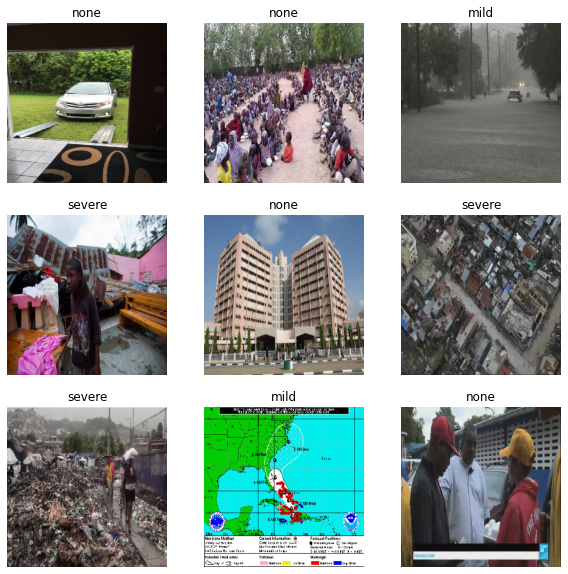

In [25]:
image_batch, label_batch = next(iter(test_ds))

plt.figure(figsize = (10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i])
    label = label_batch[i]
    plt.title(class_names[int(label)])
    plt.axis("off")

# Model Building

## Create EfficientNet architecture

In [26]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0, EfficientNetB3

def get_efficient_model(lr=0.001):
    
    tf.keras.backend.clear_session()
    print(f"lr in model = {lr}")
    pre_trained_model = EfficientNetB3(include_top=False,
                                       weights='imagenet',
                                       input_shape=(IMG_SIZE,IMG_SIZE,3))

    pre_trained_model.trainable = False

    inputs = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
    x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
    x = pre_trained_model(x,training= False)
    x = layers.GlobalAveragePooling2D()(x)
    # x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes,activation='softmax')(x)

    efficient_model = models.Model(inputs,outputs)
    efficient_model.compile(optimizer = optimizers.Adam(learning_rate=lr),
                            loss='sparse_categorical_crossentropy',
                            metrics=['acc'])

    efficient_model.summary()
    
    return efficient_model

get_efficient_model()

lr in model = 0.001
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 tf.math.multiply (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 4611      
                                                                 
Total params: 10,788,146
Trainable params

In [20]:
def subplot_learning_curve(model_name,history):
    #plt.clf()
    plt.figure(figsize=(20,5))
    for i,metric in enumerate(['acc','loss']):
        plt.subplot(1,2,i+1)
        plt.plot(history.history[metric])
        plt.plot(history.history['val_' + metric])
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend((metric, 'val_' + metric))
        plt.title(model_name + ": Learning curve " + metric + " vs " + 'val_' + metric)
    plt.show()

## Create Experiment

In [28]:
def finetune_model(lr,model_name,output_path,train_batches,valid_batches,initial_epoch,
                   epochs, steps_per_epoch,validation_steps,use_clr=False,init_lr=1e-3,max_lr=1e-2,model=None):
    print(f"finetuning lr ={lr}")
    print(f"finetuning epochs ={epochs}")
    print(f"init LR epochs ={init_lr}")
    print(f"max LR epochs ={max_lr}")
    
    if use_clr:
        print("using cyclical LR for finetuning")
        clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=init_lr,
                maximal_learning_rate=max_lr,
                scale_fn=lambda x: 1/(1.**(x-1)),
                step_size= 2 * steps_per_epoch)
        lr = clr      

    
    if model:
        for layer in model.layers:
            layer.trainable = True
        
        check = callbacks.ModelCheckpoint(f'{output_path}/{exp_name}.h5',save_best_only=True)
        early_stop = callbacks.EarlyStopping(monitor='val_acc',patience=10,restore_best_weights=True)

        model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                       loss = 'sparse_categorical_crossentropy',
                       metrics = ['acc'])

        print()
        print("Training..................")
        history = model.fit(train_batches,
                        initial_epoch=initial_epoch,
                        epochs=epochs,
                        steps_per_epoch = steps_per_epoch,
                        validation_data=valid_batches,
                        validation_steps = validation_steps,
                        callbacks=[check,early_stop])
        
        print()
        #print('loading best weights model')
        #model = models.load_model(f'{output_path}/{exp_name}.h5')
       
    return history, model

      
    
    

In [21]:
output_path = os.path.join(cwd,"outputs","model")
print(output_path)

c:\Users\wsn8\Code\disaster-damage-assessment-ml\outputs\model


In [22]:

def run_experiment(exp_name,event,model_name,is_augment=False,lr=0.001,batch_size=32,do_finetune=False,
                use_clr= False,buffer_size=10,n_epochs=20,init_lr=1e-3,max_lr=1e-2,frac=0.1):
    
    print(f"******************{exp_name}*********************************")
    print(f"model_name ={model_name}")
    print(f"data augmentation ={is_augment}")
    print(f"event ={event}")
    print(f"finetuning ={do_finetune}")
    print(f"lr ={lr}")
    print()
    
    gc.collect()
    output_path = os.path.join(cwd,"outputs","model")

    print(f"Creating dataset.....")
    train_batches,valid_batches,test_batches,steps_per_epoch,validation_steps = create_dataset(DAMAGE_PATH,
                                                                                               event,
                                                                                  is_augment=is_augment,
                                                                                  batch_size= batch_size,frac=frac)
    
    if use_clr:
        print("using cyclical LR for training")
        clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=init_lr,
                maximal_learning_rate=max_lr,
                scale_fn=lambda x: 1/(1.**(x-1)),
                step_size= 2 * steps_per_epoch)
        lr = clr
   

    print("Model architecture...........")
    if model_name == 'vgg16':
        model = get_vgg16_model(lr=lr)
    if model_name == 'vgg16_fc2':
        model = get_vgg16_fc2_model(lr=lr)
    elif model_name =='efficientnet':
        model = get_efficient_model(lr=lr) 
    elif model_name =='mobilenet':
        model = get_mobilenet_model(lr=lr)

    check = callbacks.ModelCheckpoint(f'{output_path}/{exp_name}.h5',save_best_only=True)
    early_stop = callbacks.EarlyStopping(monitor='val_acc',patience=10,restore_best_weights=True)

    print()
    print("Training..................")
    history = model.fit(train_batches,
                epochs=n_epochs,
                steps_per_epoch = steps_per_epoch,
                validation_data=valid_batches,
                validation_steps = validation_steps,
                callbacks=[check,early_stop])
    
    
    print()
    subplot_learning_curve(model_name,history)
    
    print()
    print('loading best weights model')
    #model = models.load_model(f'./model/{model_name}.h5')

    print()
    print(f"Run evaluation.........")   
  
    results_train = model.evaluate(train_batches, steps = steps_per_epoch,return_dict=True)
    results_test = model.evaluate(valid_batches, steps = validation_steps, return_dict=True)

    print()
    print(f"Training accuracy: {results_train['acc']}")
    print(f"Validation accuracy: {results_test['acc']}")
    
    if do_finetune:
        
        if not use_clr:
            #LR finetuning when not using CLR
            lr = lr * 1e-2
        print()
        print(f"******Fine tuning***********************")
        history, model = finetune_model(lr=lr,model_name=model_name, output_path = output_path,train_batches=train_batches,
                                        valid_batches=valid_batches, initial_epoch=n_epochs,epochs=2*n_epochs,
                                        steps_per_epoch=steps_per_epoch,validation_steps=validation_steps,
                                        use_clr=use_clr,init_lr=init_lr * 1e-2,max_lr=max_lr * 1e-2,model=model)
        print()
        subplot_learning_curve(model_name+"_fintuned",history)
        
        results_train = model.evaluate(train_batches, steps = steps_per_epoch,return_dict=True)
        results_test = model.evaluate(valid_batches, steps = validation_steps, return_dict=True)
        
        print()
        print(f"Training finetune accuracy: {results_train['acc']}")
        print(f"Validation finetune accuracy: {results_test['acc']}")
        

    return results_train['acc'],results_test['acc'],model,train_batches,valid_batches,test_batches,steps_per_epoch,validation_steps

# Model Training

### EfficientNet

In [23]:
event= 'cross_event_ecuador'
model_name = 'efficientnet'
exp_name = '_'.join([event,model_name,'FT'])
print(exp_name)

cross_event_ecuador_efficientnet_FT


******************cross_event_ecuador_efficientnet_FT*********************************
model_name =efficientnet
data augmentation =False
event =cross_event_ecuador
finetuning =True
lr =0.005

Creating dataset.....
Found 732 validated image filenames.
Found 23 validated image filenames.
Found 23 validated image filenames.
steps_per_epochs: 23
validations_steps: 1
Model architecture...........
lr in model = 0.005
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 tf.math.multiply (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                          

C:\Users\wsn8\AppData\Local\conda\conda\envs\disaster-damage-assessment\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


23/23 [==============================] - 113s 5s/step - loss: 0.7571 - acc: 0.6653 - val_loss: 0.5361 - val_acc: 0.6957



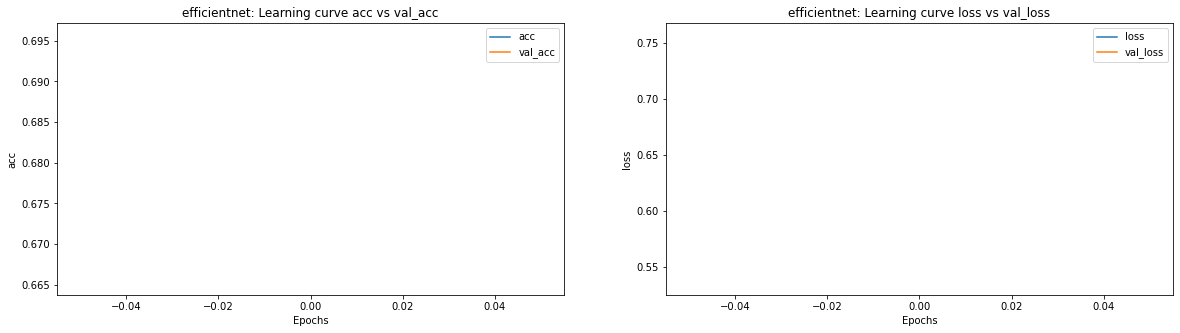


loading best weights model

Run evaluation.........
1/1 [==============================] - 4s 4s/step - loss: 0.5361 - acc: 0.6957

Training accuracy: 0.811475396156311
Validation accuracy: 0.695652186870575

******Fine tuning***********************
finetuning lr =5e-05
finetuning epochs =2
init LR epochs =1e-05
max LR epochs =0.0001

Training..................
Epoch 2/2
23/23 [==============================] - 511s 21s/step - loss: 0.4475 - acc: 0.8415 - val_loss: 0.5092 - val_acc: 0.7391




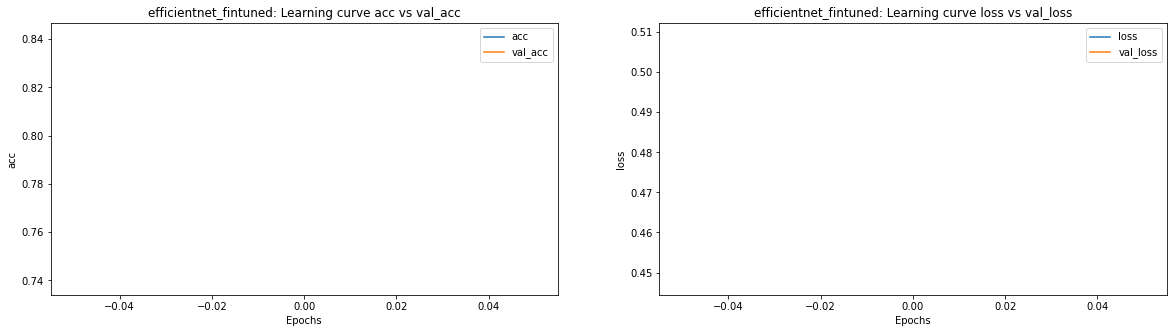

1/1 [==============================] - 4s 4s/step - loss: 0.5092 - acc: 0.7391

Training finetune accuracy: 0.9084699749946594
Validation finetune accuracy: 0.739130437374115
Wall time: 14min 6s


In [36]:
%%time

rs = run_experiment(exp_name,event,model_name,is_augment=False,lr=5 * 1e-3,batch_size=32,do_finetune=True,
                use_clr= False,buffer_size=20,n_epochs=1,init_lr=1e-3,max_lr=1e-2,frac=0.05)

# Model Evaluation

## Training, Validation and Testing accuracy

In [37]:
rs1,rs2, model,train_ds,valid_ds,test_ds,steps_per_epoch,validation_steps = rs
print(rs1,rs2)

0.9084699749946594 0.739130437374115


In [38]:
results_train = model.evaluate(train_ds, steps=steps_per_epoch, return_dict=True)
results_train

23/23 [==============================] - 123s 5s/step - loss: 0.2859 - acc: 0.8962


{'loss': 0.2859143614768982, 'acc': 0.8961748480796814}

In [39]:
results_valid = model.evaluate(valid_ds, steps=validation_steps, return_dict=True)
results_valid

1/1 [==============================] - 4s 4s/step - loss: 0.5092 - acc: 0.7391


{'loss': 0.5092034339904785, 'acc': 0.739130437374115}

In [40]:
results_test = model.evaluate(test_ds, steps=validation_steps,return_dict=True)
results_test

1/1 [==============================] - 4s 4s/step - loss: 0.4164 - acc: 0.9130


{'loss': 0.41635796427726746, 'acc': 0.9130434989929199}

In [41]:
pd.DataFrame(data={'train':results_train,'valid':results_valid,'test':results_test}).T

,loss,acc
train,0.285914,0.896175
valid,0.509203,0.739130
test,0.416358,0.913043


## Test data - Classification Report - Precision, Recall, F1 score

In [42]:
%%time
def batch_predict(ds,model,validation_steps):
    
    y_true = np.concatenate([y for x,y in ds.take(validation_steps)])
    preds = np.concatenate([model.predict(image_batch) for image_batch,label in ds.take(validation_steps)])
    print(accuracy_score(y_true,np.argmax(preds,axis=-1)))
    preds_labels = np.argmax(preds,axis=-1)
   
    results = pd.DataFrame({'y_true':y_true,
                            'y_pred':preds_labels})
    
    return results



Wall time: 0 ns


In [43]:
results = batch_predict(test_ds,model,validation_steps)

0.9130434782608695


In [44]:
def compute_metrics(pred):
    labels = pred.y_true
    preds = pred.y_pred
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels,preds,average='weighted',zero_division=0)
    recall = recall_score(labels,preds,average='weighted',zero_division=0)
    f1 = f1_score(labels,preds,average='weighted',zero_division=0)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

compute_metrics(results)

{'accuracy': 0.9130434782608695,
 'f1': 0.8918856079981399,
 'precision': 0.8792270531400966,
 'recall': 0.9130434782608695}

In [45]:
from sklearn.metrics import classification_report
print(classification_report(results.y_true, results.y_pred, target_names=class_names,zero_division=0,output_dict=False))

              precision    recall  f1-score   support

        none       1.00      0.83      0.91         6
        mild       0.00      0.00      0.00         1
      severe       0.89      1.00      0.94        16

    accuracy                           0.91        23
   macro avg       0.63      0.61      0.62        23
weighted avg       0.88      0.91      0.89        23



## Visualize predictions

In [46]:
def decode_img(file_path):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.read_file(file_path)
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  img = np.asarray(tf.cast(img, dtype=tf.float32)) * 1 / 255.0
  #img = tf.expand_dims(img, axis=0)
  return tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

In [47]:
import numpy as np

def visualize_sample_test_predictions(event,n=12):

  images_path = os.path.join(cwd,'data/ASONAM17_Damage_Image_Dataset/')
  df_test = pd.read_csv(os.path.join(cwd,f"data/damage_csv/{event}/test.csv"))
  df_test_sample = df_test.sample(n=n)

  i = 0
  plt.figure(figsize = (20, 20))
  for index,row in df_test_sample.iterrows():
      ax = plt.subplot(4, 4, i + 1)
      filename = row[0]
      true_label= row[1]
      image_file = os.path.join(images_path,filename)
      img = decode_img(image_file)
      plt.imshow(img)
      img = tf.expand_dims(img, axis=0)
      preds = model.predict(img)
      label = np.argmax(preds,axis=-1)
      title = f"label={class_names[int(true_label)]} - predict={class_names[int(label)]}"
      plt.title(title)
      plt.axis("off")
      i +=1
    



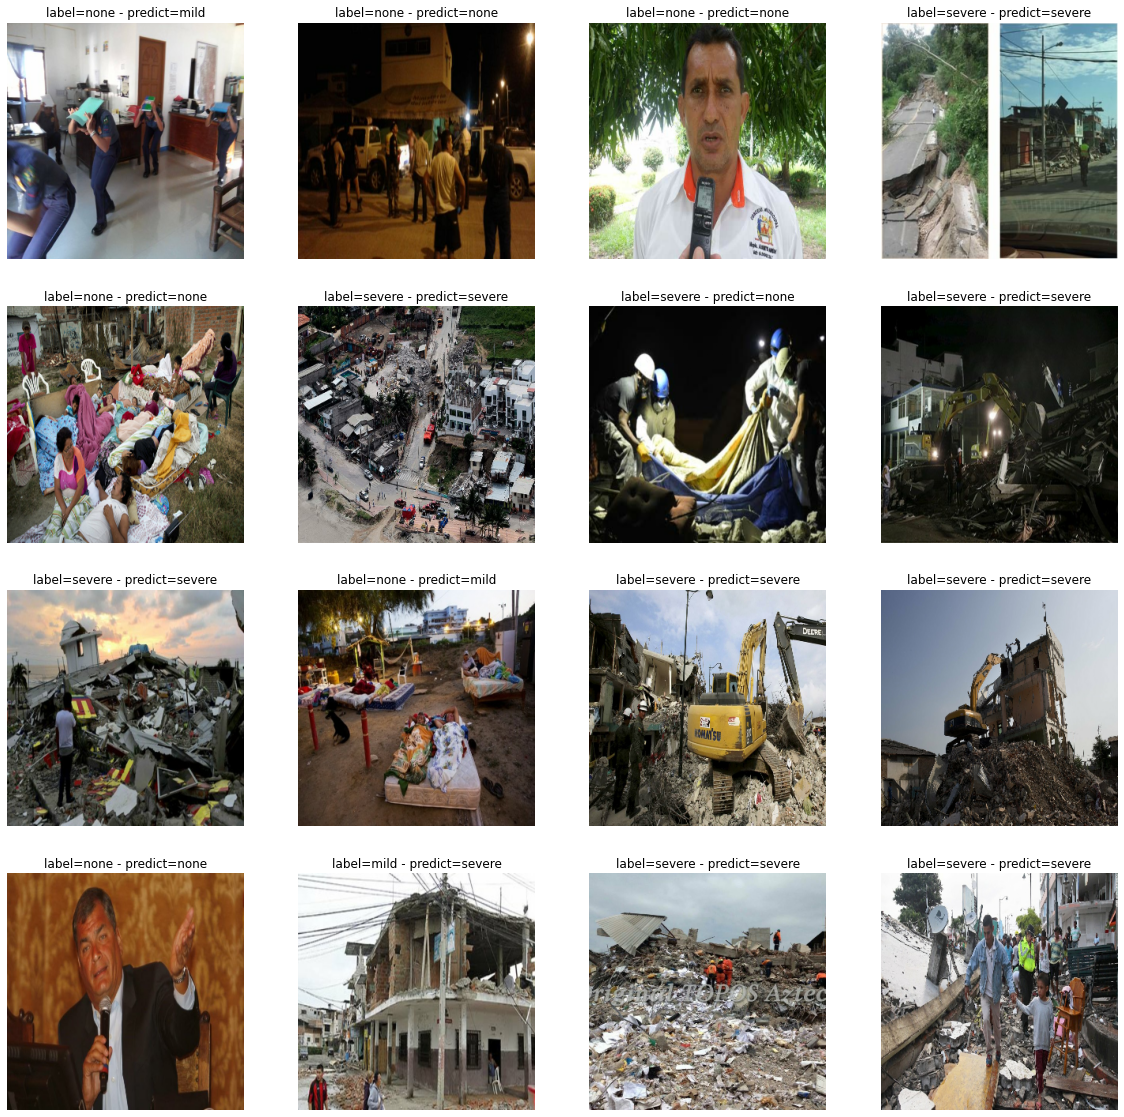

In [48]:
visualize_sample_test_predictions(event='cross_event_ecuador',n=16)  

## Classify one image 

In [49]:
def damage_classifier(image_file_path):
  image_file = os.path.join(IMAGES_PATH,image_file_path)
  img = decode_img(image_file)
  img = tf.expand_dims(img, axis=0)
  preds = model.predict(img)
  label = np.argmax(preds,axis=-1)
  probs = {lbl:preds[0][i] for i,lbl in enumerate(class_names)}

  return probs


In [50]:

img = os.path.join(cwd,'data/ASONAM17_Damage_Image_Dataset/ecuador_eq/ecuador_eq_mild_im_1007.jpg')
img2= os.path.join(cwd,'data/ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_mild_im_10.jpg')
img3=os.path.join(cwd,'data/ASONAM17_Damage_Image_Dataset/ggImage/building_damage/building_damage_1012.jpg')
damage_classifier(img3)

{'none': 0.33339238, 'mild': 0.1670916, 'severe': 0.499516}

# Damage Classifier App - Gradio

In [24]:
import gradio as gr


In [25]:
import gradio as gr
import numpy as np
print(exp_name)
outpath= os.path.join(cwd,"outputs","model")
loaded_model = models.load_model(f"{outpath}/{exp_name}.h5")
def _classifier(inp):
  img = np.asarray(tf.cast(inp, dtype=tf.float32)) * 1 / 255.0
  img = img.reshape((-1, IMG_SIZE, IMG_SIZE, 3))
  preds = loaded_model.predict(img).flatten()
  return {class_names[i]:float(preds[i]) for i in range(len(class_names))}

iface = gr.Interface(fn=_classifier, 
                     inputs=gr.inputs.Image(shape=(IMG_SIZE, IMG_SIZE)),
                     outputs=gr.outputs.Label()
                     )

iface.launch(debug=True,share=True)

cross_event_ecuador_efficientnet_FT
Running on local URL:  http://127.0.0.1:7860/
Running on public URL: https://25562.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.


(<fastapi.applications.FastAPI at 0x1ed7c5a4d88>,
 'http://127.0.0.1:7860/',
 'https://25562.gradio.app')